<a href="https://colab.research.google.com/github/gafniguy/4D-Facial-Avatars/blob/main/colab/LaMa_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦙 **LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions**

[[Project page](https://saic-mdal.github.io/lama-project/)] [[GitHub](https://github.com/saic-mdal/lama)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)]

<p align="center" "font-size:30px;">
Our model generalizes surprisingly well to much higher resolutions (~2k❗️) than it saw during training (256x256), and achieves the excellent performance even in challenging scenarios, e.g. completion of periodic structures.
</p>

# Try it yourself!👇


In [1]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet


print('\n> Changing the dir to:')
%cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

print('>fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet


print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 383 (delta 66), reused 56 (delta 48), pack-reused 269
Receiving objects: 100% (383/383), 9.87 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (127/127), done.

> Install dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision

<center>
<h1 style="font-size:10vw"><b>Predefined photo</b>: uncomment any line
<br>
<b>Local file</b>: leave the <tt>fname = None</tt></h1>
</center>

In [2]:
fname = None
# fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

/content/lama


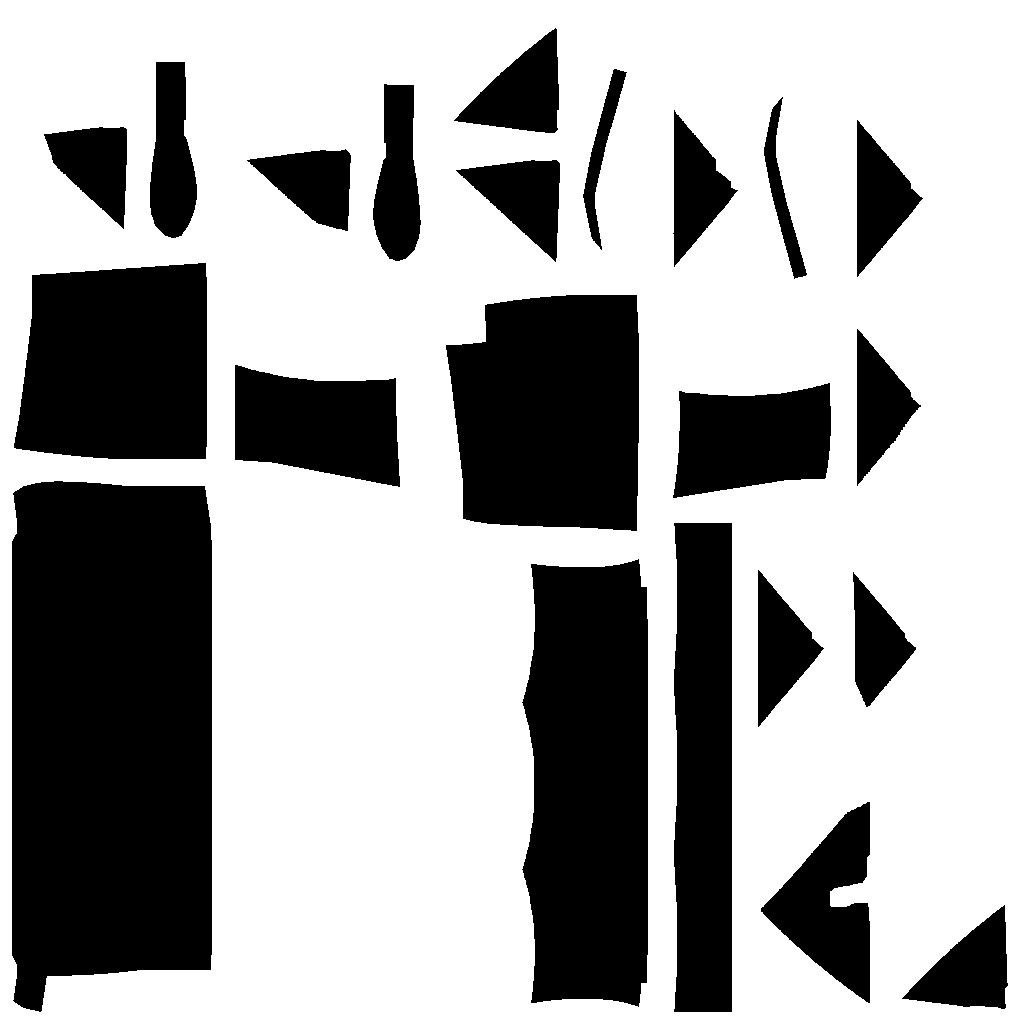

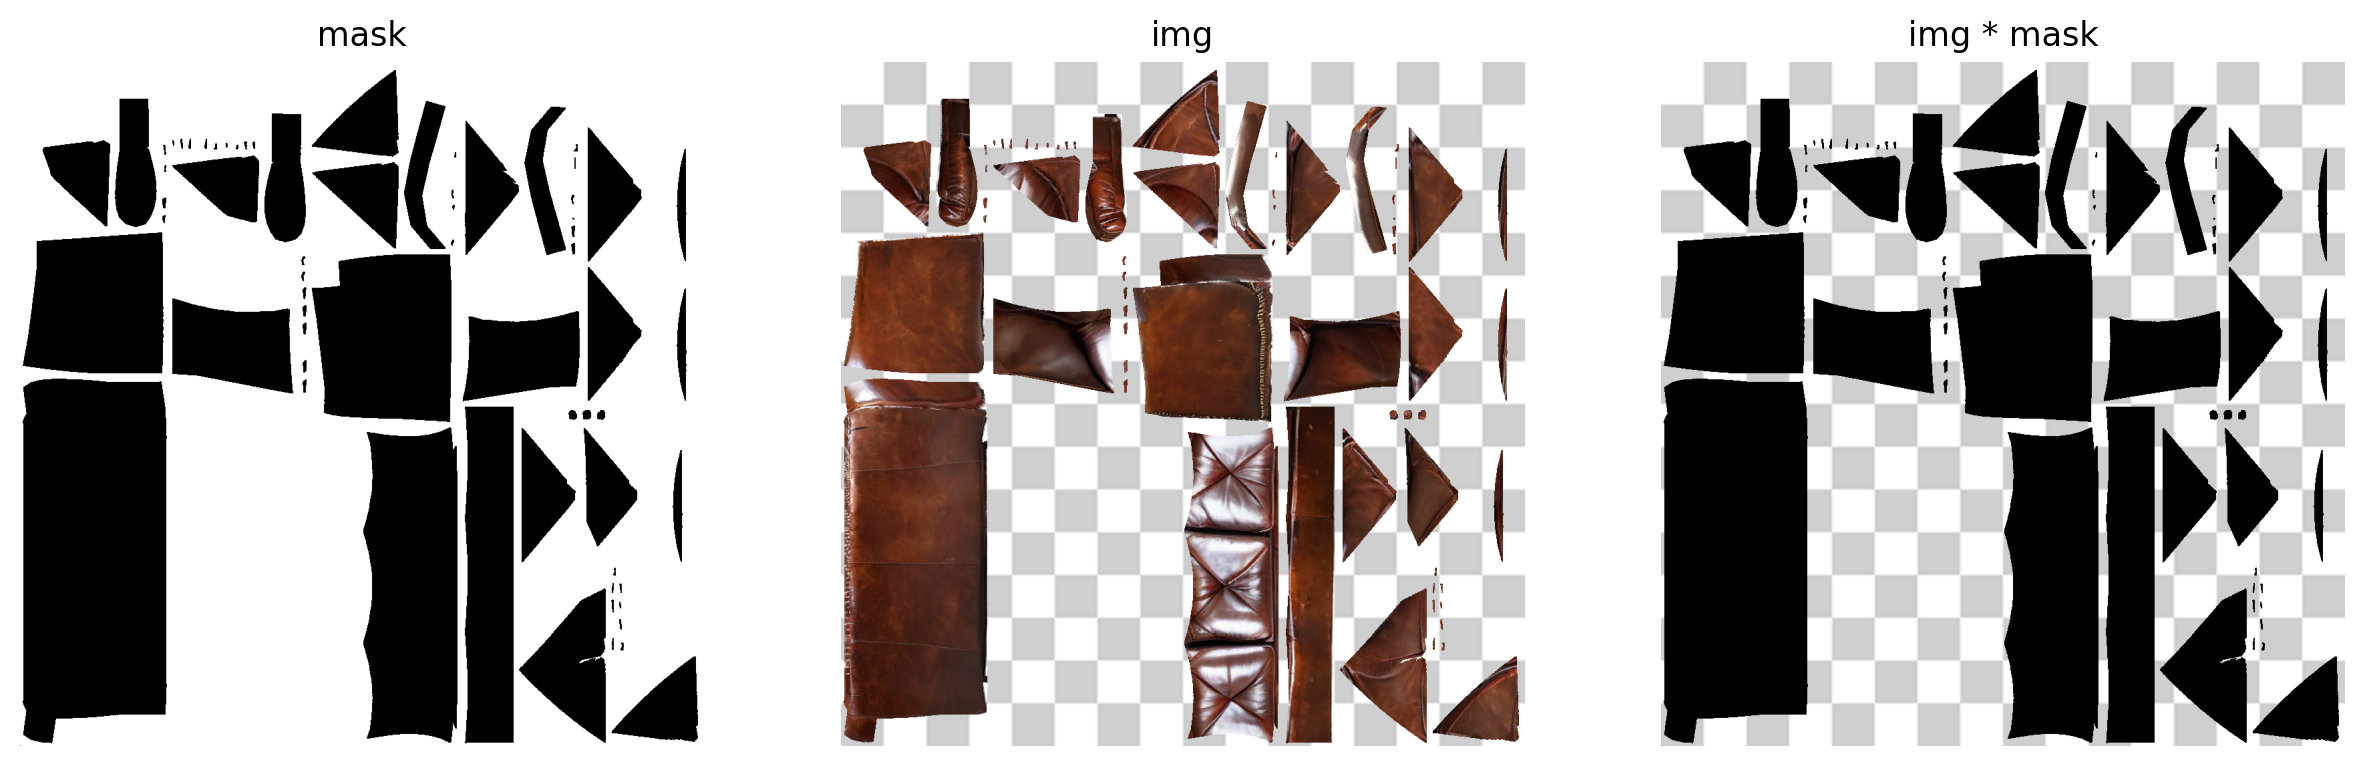

Run inpainting
100% 2/2 [00:01<00:00,  1.14it/s]


IndexError: ignored

In [75]:
#@title Draw a Mask, Press Finish, Wait for Inpainting
# fname=None
# if fname is None:
#   from google.colab import files
#   files = files.upload()
#   fname = list(files.keys())[0]
# else:
#   fname = wget.download(fname)
# print(fname)
# shutil.rmtree('./data_for_prediction', ignore_errors=True)
# !mkdir data_for_prediction

# copyfile(fname, f'./data_for_prediction/{fname}')
# os.remove(fname)
# fname = f'./data_for_prediction/{fname}'

# image64 = base64.b64encode(open(fname, 'rb').read())
# image64 = image64.decode('utf-8')

# print(f'Will use {fname} for inpainting')
# img = np.array(plt.imread(f'{fname}')[:,:,:3])

# draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
# #@title Show a masked image and save a mask
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,5)
# plt.rcParams['figure.dpi'] = 200
# plt.subplot(131)
# with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
# mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
fname="3_dummy.png"

print(os.getcwd())
plt.subplot(131)

mask = plt.imread("./3_dummy_mask_dave.png")[:,:]
mask = 1-mask
plt.imsave('./data_for_prediction/3_dummy_mask_orig.png',mask, cmap=cm.gray)

#plt.imsave("./data_for_prediction/3_dummy_mask.png",(mask))

# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.

import cv2
img = cv2.imread('./data_for_prediction/3_dummy_mask_orig.png', 0)

kernel = np.ones((15, 15), np.uint8)
img_erosion = cv2.dilate(img, kernel, iterations=1)
cv2.imwrite('./data_for_prediction/3_dummy_mask.png', img_erosion)
from google.colab.patches import cv2_imshow
cv2_imshow(img_erosion)


plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
#plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None

In [46]:
mask = plt.imread("./data_for_prediction/3_dummy_mask.png")


In [48]:
import matplotlib.cm as cm
mask = plt.imread("./data_for_prediction/3_dummy_mask.png")

plt.imsave('./data_for_prediction/filename.png',(1-mask), cmap=cm.gray)

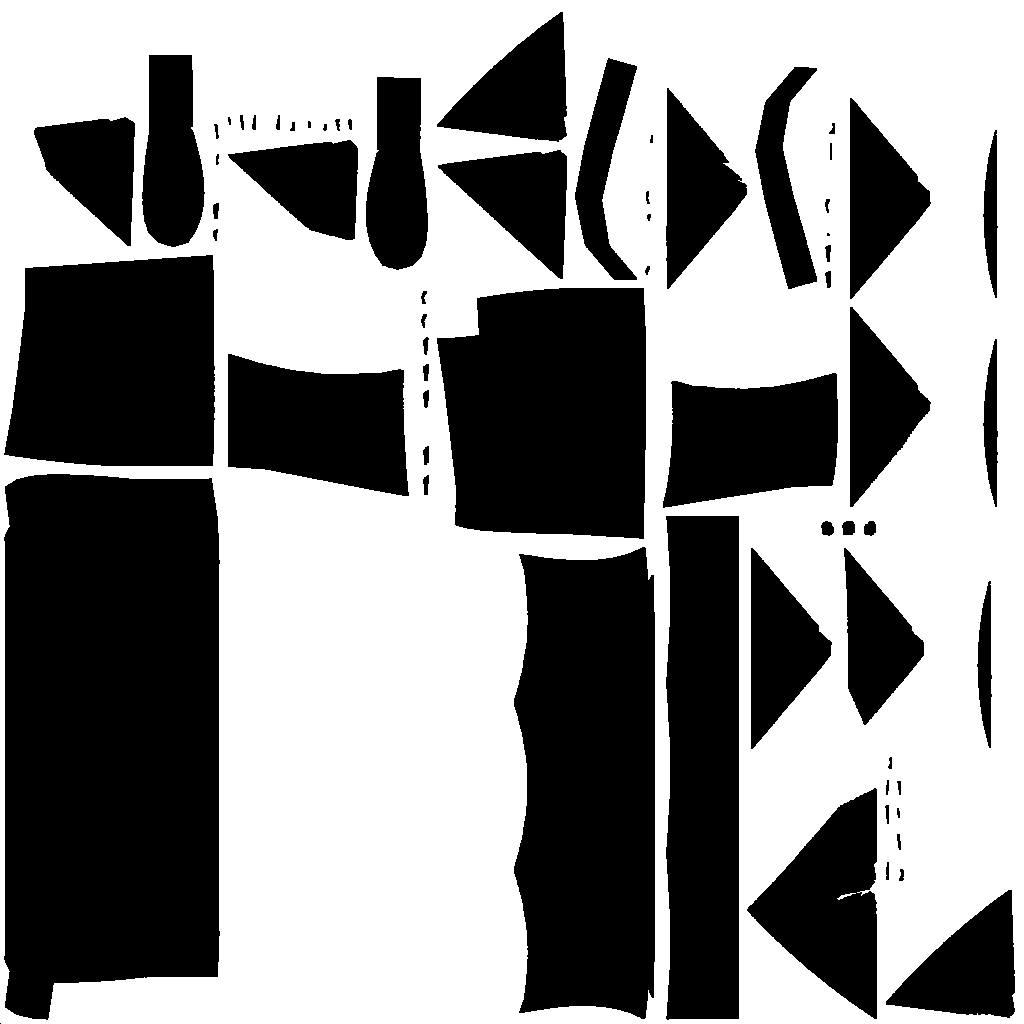

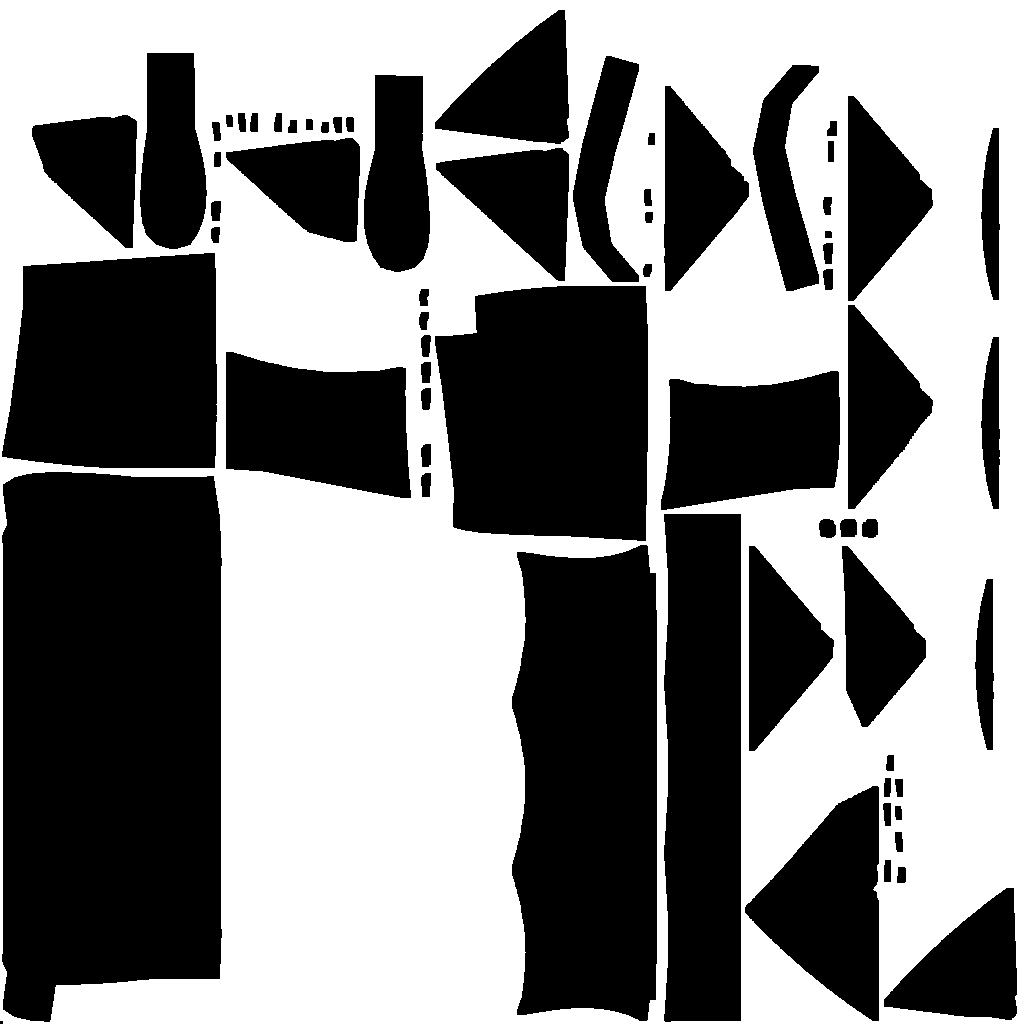

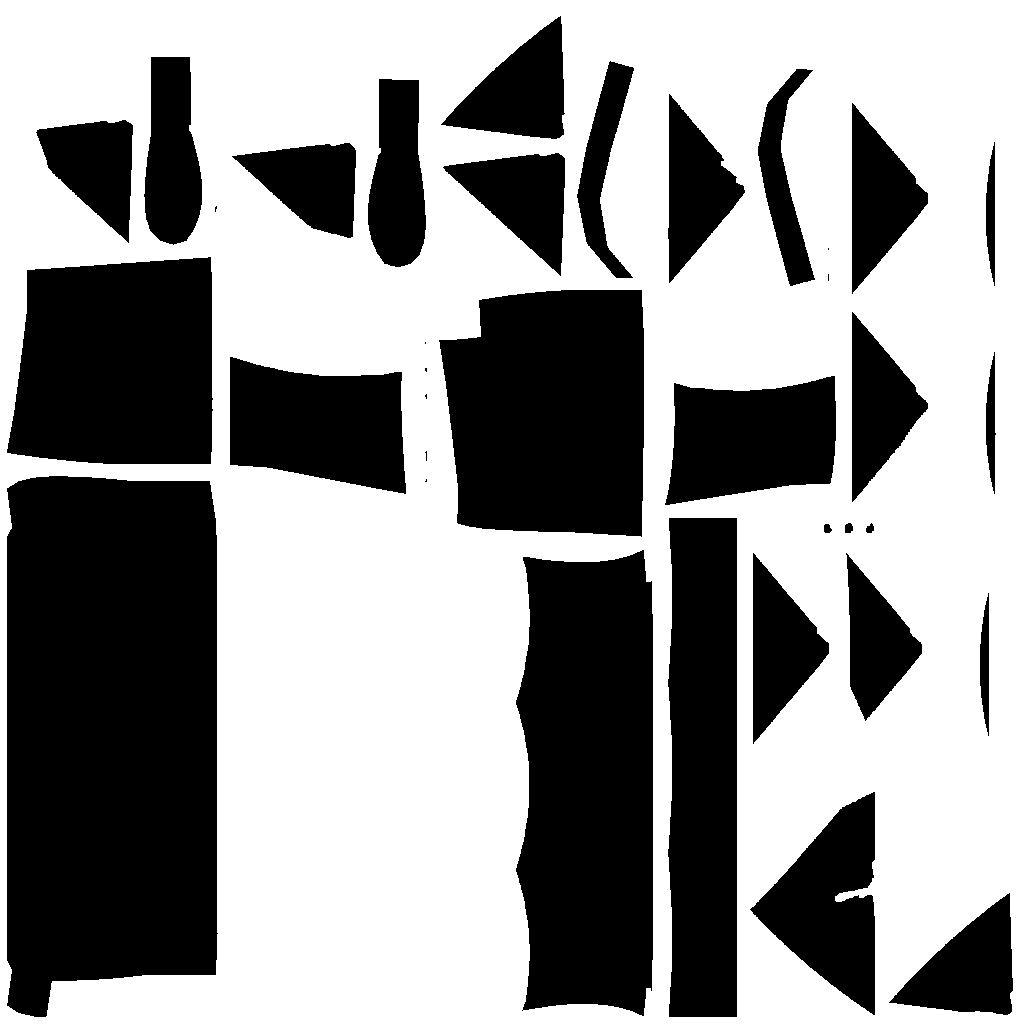

error: ignored

In [65]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Reading the input image
img = cv2.imread('./data_for_prediction/3_dummy_mask.png', 0)
# Taking a matrix of size 5 as the kernel
kernel = np.ones((5, 5), np.uint8)
  
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
img_erosion = cv2.erode(img, kernel, iterations=1)
img_dilation = cv2.dilate(img, kernel, iterations=1)
  
cv2_imshow(img)
cv2_imshow(img_erosion)
cv2_imshow(img_dilation)
  
cv2.waitKey(0)
